**Lesson 7,8 – California housing price Machine Learning application**

Try to predict median house values in Californian districts, given a number of features from these districts.

1. [Load `housing` data](#ds)
1. [Explore data](#ed)
1. [Create training set and a test set](#split)
1. [Discover and Visualize the Data to Gain Insights](#geo)
1. [Write a data preparation pipeline](#pipeline)
1. [Build a model](#build)
1. [Compute performance metrics](#metrics)

In [1]:
%run setup.ipynb

## 1. Load `housing` data <a class='anchor' id='ds'></a>

The goal is to `predict median house values` in Californian districts. The `California Hosuing Prices` dataset is based on data from 1990 California census. Dataset has been already downloaded and put in the `data` folder.

## 2. Explore `housing` data <a class='anchor' id='ed'></a>

In [2]:
def load_housing_data(housing_path=DATA_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

Let's take a peek at the top few rows of the `housing` dataset.

In [3]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

Each `row` represents `one district`. There are 10 attributes. 

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20640 entries in the dataset. It is a small dataset for ML algorithm. 
* `total_bedrooms` attribute has only 20433 non null values. There are 207 missing values.
* All attributes are numerical with the exception of `ocean_proximity` that can be considered a categorical attribute.

Check what categories exist and `how many districts` belong to `each category` (use `value_counts()`).

In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

`describe()` shows a summary of the numerical attributes. The null values are ignored.

In [6]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

The `std` row provides the standard deviation value or how dispersed the values are. The `percentile` (e.g. 25%, 50%-median, 75%) indicates the value below which a given percentage of observations in a group of observations fall.
* 25% of districts have a `housing_median_age` lower than 18
* 50% of districts have a `housing_median_age` lower than 29
* 75% of districts have a `housing_median_age` lower than 37

Saving figure attribute_histogram_plots


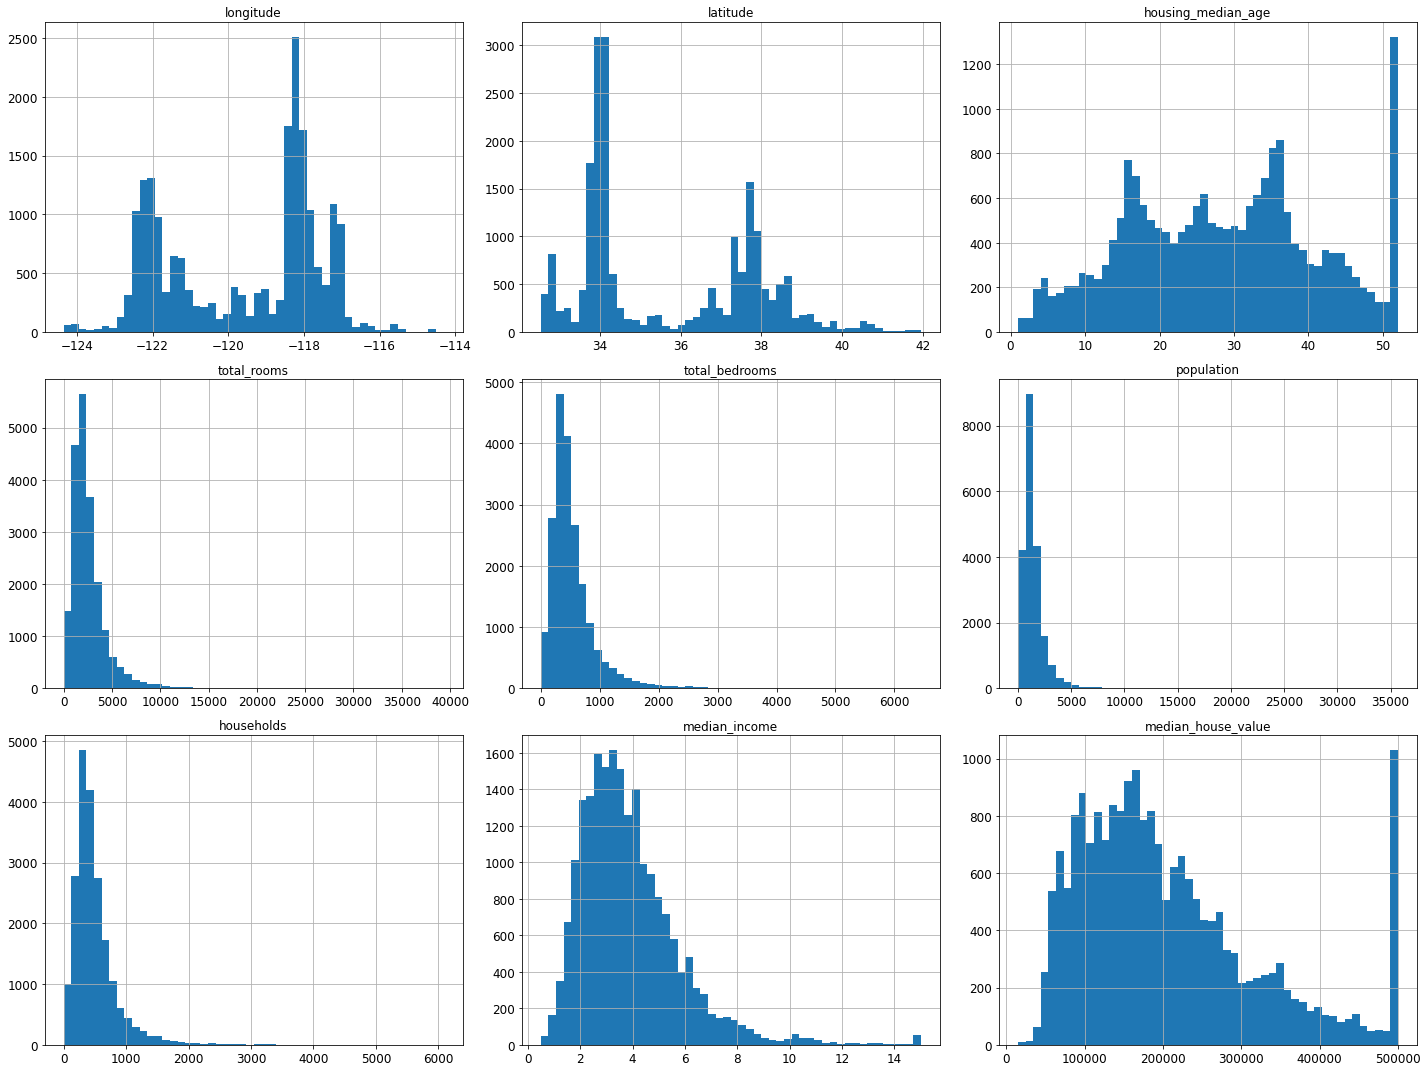

In [7]:
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

* The `median income` attribute does not look expressed in US dollar (they were already scaled and capped at 15 for higher `median incomes` and at 0.5 for lower `median incomes`.
* The `housing median age` and the `median house values` were also capped: the second one is the `target attribute` and a `limit for the prices`.
* The attributes have different scales.
* There are `tail-haivy` attributes: they extend to the right of the median than to the left.

## 3. Create a Training and Test Sets <a class='anchor' id='split'></a>

[`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function splits the dataset in training and test sets.
* `random_state` allows you to set the random generator seed and to make this notebook's output identical at every run

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [9]:
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity  
20046          INLAND  
3024           INLAND  
15663        NEAR BAY  
20484       <1H OCEAN  
9814       NEAR OCEAN

To ensure that the set is representative of the various categories of incomes, it is useful to create `income_cat` attribute according to the `median_income` values: they are mainly clustered around 1.5 to 6, and some of them are beyond 6.

<AxesSubplot:>

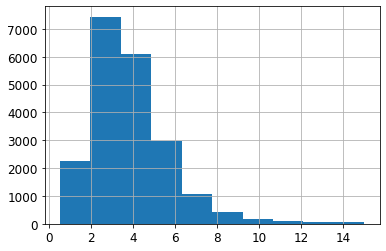

In [10]:
housing["median_income"].hist()

Use the `cut()` function to create `income_cat` with `five` categories labeled from `1` to `5`:
* category 1 ranges from 0 to 1.5
* category 2 from 1.5 to 3
* and so on

In [11]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [12]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

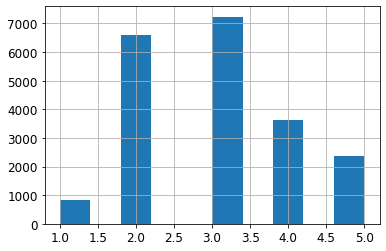

In [13]:
housing["income_cat"].hist()

Let's try [`StratifiedShuffleSplit()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) function based on the `income_cat`.
* this algorithm provides train and test indices to split data in train and test sets.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Look at the `income_cat` proportions in the test set.

In [15]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

You can measure the `income_cat` in the full dataset.

In [16]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Let's compare the `income_cat` proportions:
* in the `overall` dataset
* in the test set generated with the `stratified` sampling
* in a test set generated using `random` sampling

In [17]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [18]:
compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039729  0.040213      0.973236      -0.243309
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114583  0.109496     -4.318374       0.127011

The test set generated using `stratisfied` sampling has `income category` proportions almost identical to those in the `full` dataset.

Remove the `income_cat`.

In [19]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 4. Discover and Visualize the Data to Gain Insights <a class='anchor' id='geo'></a>

Copy the `strat_train_set` data frame.

In [20]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

Consider lat and lon information to create a scatterplot of all districts to visualize data.

Saving figure bad_visualization_plot


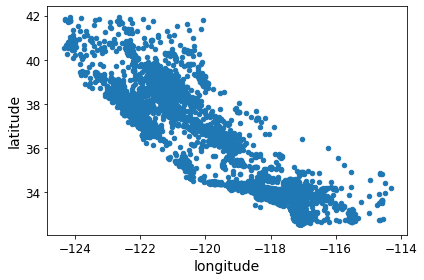

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

This looks like California but it is difficult to see details. With the `alpha` parameter it is possible to visualize the places where there is a `high density` of data points.

Saving figure better_visualization_plot


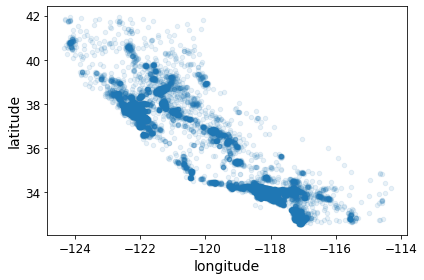

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

You can see the high-density areas are the Bay Area and around Los Angeles and San Diego, and Central Valley (Sacramento and Fresno).

Saving figure housing_prices_scatterplot


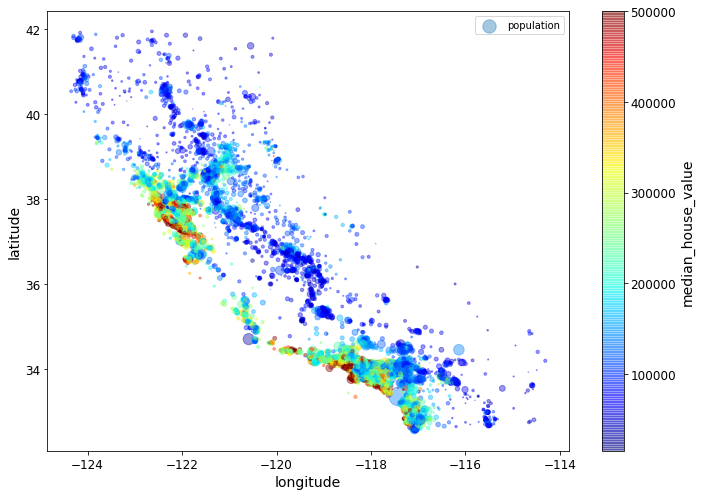

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

The radious of each circle represents the district's population (`s`), the color represents the price (`c`). `cmap` is the predefined color map (set to `jet`): blue means low prices, red means high prices. The housing prices are very much relatred to the location and the population density.

In [24]:
# the California image
filename="california_1.png"

Saving figure california_housing_prices_plot


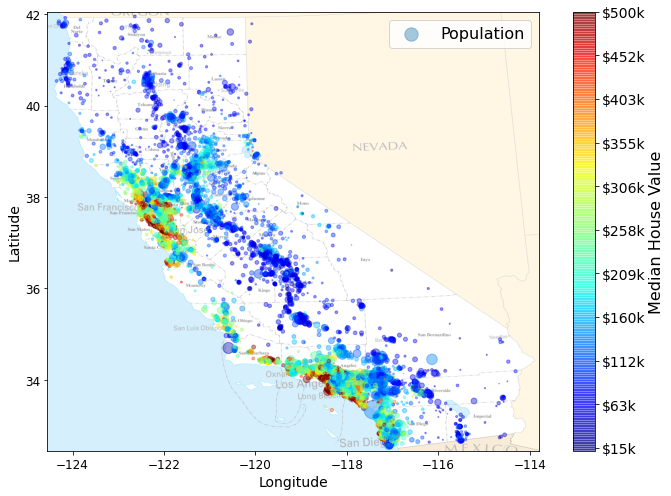

In [25]:
california_img=mpimg.imread(os.path.join(IMAGES_PATH, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

You can observe the Bay Area, around Los Angeles and San Diego, around Sacramento and Fresno.

### Looking for Correlations

In [26]:
corr_matrix = housing.corr()

Detect how each attribute correlates with the `median house value`. Use the `corr_matrix()` function.

In [27]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from -1 to 1:
* Close to 1 means that there is a strong positive correlation (`median house value` up and `median income` up)
* Close to -1 means that there is a strong negative correlation (`latitude` and `median house value` have a small negative correlation - prices go down when you go north)
* Close to 0 means that there is no linear correlation

You can do the same with the `scatter_matrix()` function, applied to a subset of attributes. It draws a matrix of scatter plot.

Saving figure scatter_matrix_plot


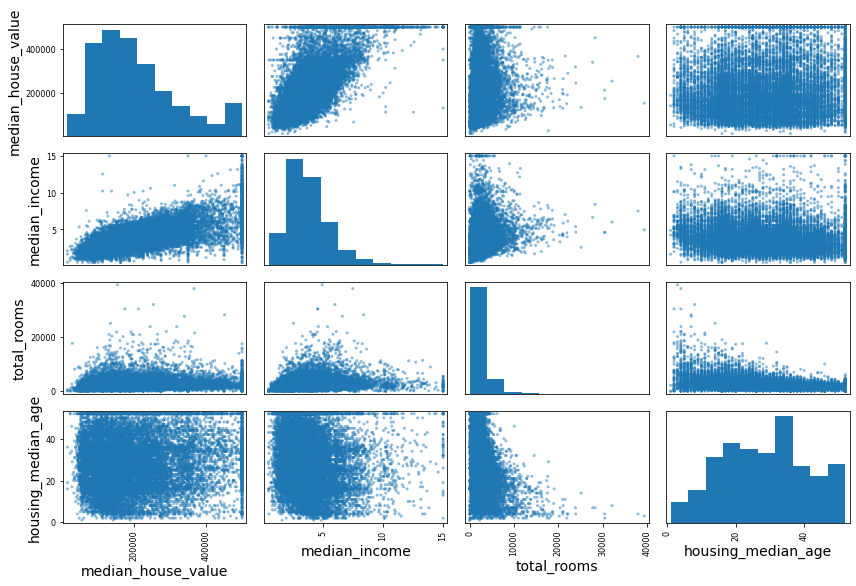

In [28]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

The main diagonal shows a histogram of each attribute.

The most promising attribute to predict the `median house value` is the `median income`.

Saving figure income_vs_house_value_scatterplot


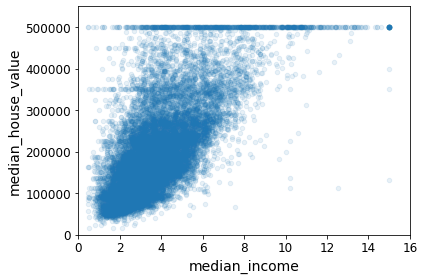

In [29]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

The correlation is quite strong. There is an `upward` trend and the points are not dispersed particularly. 
* The price cap is visible at the horizontal line at `500000` dollar.
* There is another cap at around `450000` dollar.
* Another cap at `350000` dollar.
* Maybe some other caps below.

### Combining attributes

In addition to the `total rooms` in a district, it could be interested in
* Determining `rooms per household`
* Determining `bedrooms per household`
* Determining `populations per household`

In [30]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Compute again correlation coefficient.

In [31]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

`bedrooms per room` is more correlated with the `median house value` than the `total bedrooms` or `total number of rooms`.
* Houses with a `lower bedrooms/rooms` are more expensive.

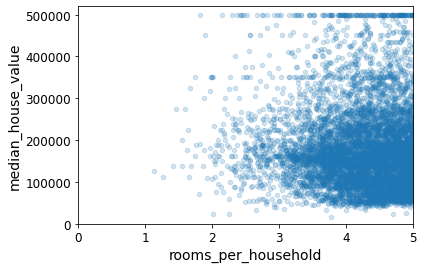

In [32]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

`number of rooms per household` is more informative than `total number of rooms` in a district.
* Larger houses are more expensive, too.

In [33]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.575834     35.639577           28.653101   2622.728319   
std        2.001860      2.138058           12.574726   2138.458419   
min     -124.350000     32.540000            1.000000      6.000000   
25%     -121.800000     33.940000           18.000000   1443.000000   
50%     -118.510000     34.260000           29.000000   2119.500000   
75%     -118.010000     37.720000           37.000000   3141.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    16354.000000  16512.000000  16512.000000   16512.000000   
mean       534.973890   1419.790819    497.060380       3.875589   
std        412.699041   1115.686241    375.720845       1.904950   
min          2.000000      3.000000      2.000000       0.499900   
25%        295.000000    784.000000    279.000000       2.566775   
50%        433.000000   1164.000000    408.000000       3.540900   
75%        644.000000   1719.250000    602.000000       4.744475   
max       6210.000000  35682.000000   5358.000000      15.000100   

       median_house_value  rooms_per_household  bedrooms_per_room  \
count        16512.000000         16512.000000       16354.000000   
mean        206990.920724             5.440341           0.212878   
std         115703.014830             2.611712           0.057379   
min          14999.000000             1.130435           0.100000   
25%         119800.000000             4.442040           0.175304   
50%         179500.000000             5.232284           0.203031   
75%         263900.000000             6.056361           0.239831   
max         500001.000000           141.909091           1.000000   

       population_per_household  
count              16512.000000  
mean                   3.096437  
std                   11.584826  
min                    0.692308  
25%                    2.431287  
50%                    2.817653  
75%                    3.281420  
max                 1243.333333

## 5. Prepare the Data for Machine Learning Algorithms <a class='anchor' id='pipeline'></a>

* Restart from a clean dataset by using the `strat_train_set` data frame.

Handle missing values, categorical attributes

* Separate the predictors (i.e `median_house_value`) by the labels 

In [34]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

#### Missing values

ML algorithms do not work with missing values. The critical variable is `total_bedrooms`. It is possible to solve this problem in various ways:

1. removing `na` values `housing.dropna(subset=["total_bedrooms"])`
2. removing the variable `housing.drop("total_bedrooms", axis=1)`
3. replacing `na` with median values

````
median = housing["total_bedrooms"].median() 
housing["total_bedrooms"].fillna(median, inplace=True)
````

In the third case you need to save the `median value` to put in the test set when you evaluate the model.

Create a copy of the housing dataset, `keeping only the rows that contain at least one null`. The `NaN` values are in the `total_bedrooms` attribute.

In [35]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0             NaN   
6068     -117.86     34.01                16.0       4632.0             NaN   
17923    -121.97     37.35                30.0       1955.0             NaN   
13656    -117.30     34.05                 6.0       2155.0             NaN   
19252    -122.79     38.48                 7.0       6837.0             NaN   

       population  households  median_income ocean_proximity  
4629       3296.0      1462.0         2.2708       <1H OCEAN  
6068       3038.0       727.0         5.1762       <1H OCEAN  
17923       999.0       386.0         4.6328       <1H OCEAN  
13656      1039.0       391.0         1.6675          INLAND  
19252      3468.0      1405.0         3.1662       <1H OCEAN

In [36]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"]) # option 1 removing `na` values `housing.dropna(subset=["total_bedrooms"])`

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity]
Index: []

In [37]:
sample_incomplete_rows.drop("total_bedrooms", axis=1) # option 2 removing the variable `housing.drop("total_bedrooms", axis=1)`

longitude  latitude  housing_median_age  total_rooms  population  \
4629     -118.30     34.07                18.0       3759.0      3296.0   
6068     -117.86     34.01                16.0       4632.0      3038.0   
17923    -121.97     37.35                30.0       1955.0       999.0   
13656    -117.30     34.05                 6.0       2155.0      1039.0   
19252    -122.79     38.48                 7.0       6837.0      3468.0   

       households  median_income ocean_proximity  
4629       1462.0         2.2708       <1H OCEAN  
6068        727.0         5.1762       <1H OCEAN  
17923       386.0         4.6328       <1H OCEAN  
13656       391.0         1.6675          INLAND  
19252      1405.0         3.1662       <1H OCEAN

For the option 3 , you need to compute the `medial values` on the training set and use it to fill the missing values in the training set.


**NOTE**: You have to save the median value in order to replace missing values in the test set when you need to evaluate the system and when you add new data.

In [38]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3 replacing `na` with median values

In [39]:
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   

       population  households  median_income ocean_proximity  
4629       3296.0      1462.0         2.2708       <1H OCEAN  
6068       3038.0       727.0         5.1762       <1H OCEAN  
17923       999.0       386.0         4.6328       <1H OCEAN  
13656      1039.0       391.0         1.6675          INLAND  
19252      3468.0      1405.0         3.1662       <1H OCEAN

Use [`SimpleImputer()`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) function to replace `na` values with the `median` values. The `strategy` parameter allows you to specify the imputation strategy.

In [40]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the `text attribute`, because `median` can only be calculated on numerical attributes. So create a copy of the data without text attribute, so remove `ocean_proximity`.

In [41]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [42]:
housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  
17606       710.0       339.0         2.7042  
18632       306.0       113.0         6.4214  
14650       936.0       462.0         2.8621  
3230       1460.0       353.0         1.8839  
3555       4459.0      1463.0         3.0347

You can `fit` the `imputer` instance to the training data with the `fit()` function. `imputer` computes the median to the numerical attributes and stores results in `statistics_` variable.

In [43]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [44]:
housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  
17606       710.0       339.0         2.7042  
18632       306.0       113.0         6.4214  
14650       936.0       462.0         2.8621  
3230       1460.0       353.0         1.8839  
3555       4459.0      1463.0         3.0347

Only `total_bedrooms` had missing values. You might have missing values in new data.

In [45]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Check that this is the same as manually computing the median of each attribute:

In [46]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

At this point you can `define` the training set by replacing the missing values with the median values of the learned medians.

In [47]:
X = imputer.transform(housing_num)

X is a numpy array containing the transformed features. You get the same results by applyting the `fit_transform()` function.

In [48]:
print(X)

[[-121.89     37.29     38.     ...  710.      339.        2.7042]
 [-121.93     37.05     14.     ...  306.      113.        6.4214]
 [-117.2      32.77     31.     ...  936.      462.        2.8621]
 ...
 [-116.4      34.09      9.     ... 2098.      765.        3.2723]
 [-118.01     33.82     31.     ... 1356.      356.        4.0625]
 [-122.45     37.77     52.     ... 1269.      639.        3.575 ]]


In [49]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [50]:
housing_tr.loc[sample_incomplete_rows.index.values]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   

       population  households  median_income  
4629       3296.0      1462.0         2.2708  
6068       3038.0       727.0         5.1762  
17923       999.0       386.0         4.6328  
13656      1039.0       391.0         1.6675  
19252      3468.0      1405.0         3.1662

In [51]:
imputer.strategy

'median'

In [52]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [53]:
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  
17606       710.0       339.0         2.7042  
18632       306.0       113.0         6.4214  
14650       936.0       462.0         2.8621  
3230       1460.0       353.0         1.8839  
3555       4459.0      1463.0         3.0347

#### Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`.

In [54]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

Convert these categories from text to numbers. Try [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) function that encodes categorical features as an integer array.

In [55]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [56]:
np.unique(housing_cat_encoded)

array([0., 1., 2., 3., 4.])

The `ordinal_encoder` stores the list of categories in its `categories_` variable. It is a list of 1D array of categories for each categorical attribute: (in this case we have just 1 categorical attribute).

In [57]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

By using the `OrdinalEncoder` approach ML techniques will assume that two nearby values are more similar than two distant values. This is not the case for this example, where categories `0=<1H OCEAN` and `4=NEAR OCEAN` are similar than `0=<1H OCEAN` and `1=INLAND`. 

Try [`OneHotEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function that encodes categorical features as a one-hot numeric array. It allows you to create a binary attribute per category. For example:
* one attribute is equal to 1 when category is `<1H OCEAN`, 0 otherwise;
* one attribute is equal to 1 when category is `1=INLAND`, 0 otherwise;
* and so on
This approach is called `one-hot encoding` because only one attribute will be equal to 1, while the others will be 0.

In [58]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` returns a sparse matrix. Each row is full of 0s except for a single 1 per row. This can consume tons of memory, you can only store the location of hte nonzero elements. You can convert the sparse matrix to a dense array, if needed, by calling the `toarray()` function. 

In [59]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [60]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

You can list the encoder's `categories_` variable.

In [61]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### Custom Transformers

Let's create a `custom transformer` to perform clean operations or combine specific attributes or add extra attributes. Use [`BaseEstimator`](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) to get and set new hyperparameter, and [`TransformerMixin`](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) to perform a fit trasformer operation. 

Create a `CombinedAttributesAdder` class, that is a new type of object that allows new instances of that type to be made:
* Each class instance can have attributes attached to it for maintaining its state. 
* Class instances can also have methods (defined by its class) for modifying its state.

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
col_names = ["total_rooms", "total_bedrooms", "population", "households"]
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices
print(rooms_ix, bedrooms_ix, population_ix, households_ix)

# Here it is a defined a class object
class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

3 4 5 6


This class allows you to add a new hyperparameter `add_bedrooms_per_room`.

In [63]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

`housing_extra_attribs` is a NumPy array, we've lost the column names. To recover a `DataFrame`, you could run this:

In [64]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms  \
17606   -121.89    37.29               38.0      1568.0          351.0   
18632   -121.93    37.05               14.0       679.0          108.0   
14650    -117.2    32.77               31.0      1952.0          471.0   
3230    -119.61    36.31               25.0      1847.0          371.0   
3555    -118.59    34.23               17.0      6592.0         1525.0   

      population households median_income ocean_proximity rooms_per_household  \
17606      710.0      339.0        2.7042       <1H OCEAN            4.625369   
18632      306.0      113.0        6.4214       <1H OCEAN             6.00885   
14650      936.0      462.0        2.8621      NEAR OCEAN            4.225108   
3230      1460.0      353.0        1.8839          INLAND            5.232295   
3555      4459.0     1463.0        3.0347       <1H OCEAN             4.50581   

      population_per_household  
17606                 2.094395  
18632                 2.707965  
14650                 2.025974  
3230                  4.135977  
3555                  3.047847

#### Feature Scaling

Some ML techniques do not perform wekk when the input have different scales:
* total number of rooms `total_rooms` ranges from 6 to 39,320
* `median_income` ranges from 0 to 15

In [65]:
print(housing_extra_attribs.total_rooms.min(), housing_extra_attribs.total_rooms.max())

6.0 39320.0


In [66]:
print(housing_extra_attribs.median_income.min(), housing_extra_attribs.median_income.max())

0.4999 15.0001


Two simple ways to get all attributes with the same scale are:
* `min-max scaling or normalization`: all values are shifted and rescaled so that they end up ranging from 0 to 1. First subtract the min value and then divide by the max minus the min. This approach is supported by [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) class.
* `standardization`: first it subtracts the mean value and then it divides by the standard deviation. This approach is supported by [`StandardScaler()`](https://www.google.com/search?q=standard+scaler&oq=standard+scaler&aqs=chrome..69i57j0i10i512j0i20i263i512j0i512l7.2497j0j4&sourceid=chrome&ie=UTF-8) class.

You need to apply this procedure to the training data only.

#### Transformation Pipelines

The [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class helps with the data cleaning steps.

Now let's build a pipeline for preprocessing the numerical attributes:

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

The `Pipeline` class takes a list of `name/estimator` pairs defining a sequence steps. 
* The `names` must be unique and do not contain `__`.
* The `estimators` are `transformers`.
The `num_pipleline` object calls `fit_transform()` sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator.

In [68]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

Now let's build a pipeline for preprocessing both the numerical attributes and categorical attributes. Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) class that applies transformers to columns of an array or pandas DataFrame.

In [69]:
housing_num

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   
...          ...       ...                 ...          ...             ...   
6563     -118.13     34.20                46.0       1271.0           236.0   
12053    -117.56     33.88                40.0       1196.0           294.0   
13908    -116.40     34.09                 9.0       4855.0           872.0   
11159    -118.01     33.82                31.0       1960.0           380.0   
15775    -122.45     37.77                52.0       3095.0           682.0   

       population  households  median_income  
17606       710.0       339.0         2.7042  
18632       306.0       113.0         6.4214  
14650       936.0       462.0         2.8621  
3230       1460.0       353.0         1.8839  
3555       4459.0      1463.0         3.0347  
...           ...         ...            ...  
6563        573.0       210.0         4.9312  
12053      1052.0       258.0         2.0682  
13908      2098.0       765.0         3.2723  
11159      1356.0       356.0         4.0625  
15775      1269.0       639.0         3.5750  

[16512 rows x 8 columns]

In [70]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs), #num_attribs transformed with num_pipeline
        ("cat", OneHotEncoder(), cat_attribs), #cat transformed with onehotencoder
    ])

housing_prepared = full_pipeline.fit_transform(housing)

The `ColumnTransformer()` function requires a list of tuples, where each tuple contains a name, a transformer and a list of names (or indices) of columns that the transformer should be applied to.  

The `full_pipeline` object applies a `fit_transform()` to the housing data. 

In [71]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [72]:
type(housing_prepared)

numpy.ndarray

In [73]:
housing_prepared.shape

(16512, 16)

## 6. Select and Train a Model <a class='anchor' id='model'></a>

### Training and Evaluating on the Training Set

Let's first train a Linear Regression model.

In [74]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Let's try the full preprocessing pipeline on a few training instances: the first 5 rows.

In [75]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Compare predictions against the actual values.')
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels)) 
print(100-100*lin_reg.predict(some_data_prepared)/list(some_labels))

Compare predictions against the actual values.
Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]
[ 26.50223147   6.70322755  -7.13886913 -27.90278373  25.44300255]


The predictions are not exactly accurate. 

## 7. Compute performance metrics <a class='anchor' id='metrics'></a>

To measure this regression model performance you can use the [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) function that performs a mean squared error regression loss.

In [76]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

**Note**: you can get the RMSE directly by calling the `mean_squared_error()` function with `squared=False`.

In [77]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

68628.19819848923

In [78]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

This result is not very good, mainly because it shows a prediction error of 68,628 dollar. 

It seems that the model underfit the training data, due to the features that do not provide enough information or the model that is not powerful enough.

To fix underfitting, you can select a powerful model or add more features.

Let's try a `Decition Tree Regressor` model that is capable of finding complex nonlinear relationships in the data.

In [79]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [80]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Here the error is 0. The model maybe has overfit the data. To check this you can follow one of the following solutions:
* use part of the training set for training and part of it for model validation
* use k-fold cross validation feature

### Better Evaluation Using Cross-Validation

The [`cross-validation`](https://scikit-learn.org/stable/modules/cross_validation.html) approach  uses different portions of the data to test and train a model on different iterations. You can use the [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function to randomly splits the training set into `k` distinct subsets called `folds`, then it trains and evaluates a model `k` times, picking a different `fold` for evaluation every time and training on the other `k-1` folds. 

In the following code, `k` is set to 10. The result is an array containing the 10 evaluation scores. 

In [81]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [82]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


The Decision Tree has a score of approximately 71,407 with +/- 2,439. 

Let's compute the same scores for Linear Regression.

In [83]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


The `Decision Tree` model seems to perform worse than the `Linear Regression` model due to the ovefitting. 

Let's try another model: `RandomForestRegressor`. Random Forest works by training many Decision Trees on random subsets of the features, than averaging out their predictions. It is an `Ensemble learning` model, because it builds a model on top of many other models.

In [84]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [85]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [86]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [87]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

Let's try another model: `Support Vector Machine`. 

Below the SVR (Epsilon-Support Vector Regression) model is used with the `kernel=linear` parameter.

In [88]:
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

118580.68301157995

In [89]:
svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [111389.0681902  119541.25938571 116957.62830414 120447.19932481
 117618.15904234 122309.10351544 117634.40230741 121469.713921
 120343.01369623 118017.12860651]
Mean: 118572.66762937943
Standard deviation: 2936.877586794944
